In [1]:
import pandas as pd
import numpy as np
import import_ipynb
import utils_cdt as cdt
from datetime import datetime
from pyspark.sql import SparkSession, Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel 
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
import matplotlib.pyplot as plt
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils_cdt.ipynb


In [2]:
infoDataBases = {"ip":"AZ2D-MASKDB-220.DEVCDT.COM.BR","base":"Fortbrasil"}

In [3]:
preditoras = ['RotativoPagaJuros','LancadoAfetaRotativo','RotativoAliquota']
prevista = ['Valor']

In [4]:
def cache(self): 
    """ 
    Persist this RDD with the default storage level (C{MEMORY_ONLY_SER}). 
    """ 
    self.is_cached = True 
    self.persist(StorageLevel.MEMORY_ONLY_SER) 
    return self 

In [5]:
spark = SparkSession \
    .builder \
    .appName("Modelo - Spark") \
    .config("spark.executor.memory", "4gb") \
    .config("spark.driver.host","127.0.0.1") \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Modelo - Spark>

In [ ]:
#Consulta de BASE SQL Server
consulta = cdt.resultQuery("mdl_iof_rotativo.sql")
df = cdt.extrairDados(infoDataBases,consulta,path="../data/",arquivo="mdl_iof_rotativo_"+infoDataBases["base"]+".csv",spark=False,objSpark=spark)

In [ ]:
df.drop('DataGeracao', inplace=True, axis=1)
df.head()

In [ ]:
df.plot.scatter('RotativoPagaJuros','Valor')

In [ ]:
#Substituindo valores negativos pelo proprio valor positivo
df = df.abs()

In [ ]:
df.head()

In [ ]:
X_treino, Y_treino, X_teste, Y_teste = cdt.preperTreinoTeste(df, preditoras, prevista, split = 0.3)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
modelTreeRegressor = DecisionTreeRegressor(min_samples_leaf=10,min_samples_split=500).fit(X_treino, Y_treino)
TreeRegrssor = DecisionTreeRegressor()

In [ ]:
# Utiliza o GridSearch para encontrar o melhor parametro do TreeRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {"min_samples_leaf":[10,30,4,15],"min_samples_split":[2,100,500,1000]}
search = GridSearchCV(TreeRegrssor, param_grid)
search.fit(X_treino, Y_treino)
search.best_params_

In [ ]:
modelTreeRegressor.score(X_teste,Y_teste)

In [ ]:
#Retirando metrcias do modelo 
Y_Predict = modelTreeRegressor.predict(X_teste)
Y_Predict = Y_Predict.reshape(Y_Predict.shape[0],1)
df_final = cdt.transformDataSet(Y_Predict, Y_teste)
cdt.getresultdataset(df_final, "DecisionTreeRegressor")

In [ ]:
filename = 'models/mdl_iof_rotativo_'+infoDataBases["base"]+'.sav'
pickle.dump(modelTreeRegressor, open(filename, 'wb'))

## Prevendo novos valores com base no Modelo treinado anteriormente

In [519]:
#Carregando modelo 
model_treeRegressor = pickle.load(open('models/mdl_iof_rotativo_'+infoDataBases["base"]+'.sav', 'rb'))

In [520]:
#Consulta de BASE SQL Server
consulta = cdt.resultQuery("iof_rotativo.sql")
df = cdt.extrairDados(infoDataBases,consulta,arquivo="iof_rotativo_"+infoDataBases["base"]+".csv",spark=False,objSpark=spark)

In [521]:
df.head(2)

,DataGeracao,Id_Conta,RotativoPagaJuros,RotativoAliquota,LancadoAfetaRotativo,Valor
0,2019-12-02,288028,570.34,0.0,570.34,7.44
1,2019-12-02,308594,0.00,0.0,-62.87,0.30


In [522]:
df.drop('DataGeracao', inplace=True, axis=1)
df.head()

,Id_Conta,RotativoPagaJuros,RotativoAliquota,LancadoAfetaRotativo,Valor
0,288028,570.34,0.0,570.34,7.44
1,308594,0.00,0.0,-62.87,0.30
2,318481,0.00,0.0,0.00,1.00
3,327196,0.00,0.0,0.00,3.21
4,350109,0.00,0.0,0.00,0.59


In [523]:
X, Y = preperData(df, preditoras,prevista)

In [524]:
model_forest.score(X,Y)

-0.0076279036714341775

In [525]:
#Retirando metrica SE - Sum of Error do modelo 
Y_Predict = model_treeRegressor.predict(X)
Y_Predict = Y_Predict.reshape(Y_Predict.shape[0],1)
df_final = transformDataSet(Y_Predict, Y)
getresultdataset(df_final, "model_forest")

[model_forest] - Total Real:  628.00
[model_forest] - Total Prev:  683.22
[model_forest] - Total Diff:  55.22
[model_forest] - Total Porcentagem de diferença do previsto x real:  8.79%


Text(0.5, 1.0, 'Importância de cada feature no Valor Minimo Extrato')

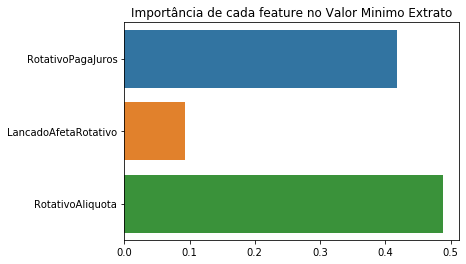

In [526]:
import seaborn as sns
importances = pd.Series(data=randomForestRegression.feature_importances_, index=preditoras)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature no Valor Minimo Extrato')